In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data.dataset import Dataset
import cv2

import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IM_SIZE = 128 # 2**7
INNER_SIZE = 4 # 2**2
DEGREE = 4 # (6-2)-1

# Создаем датасет

In [ ]:
from numpy import inf

def process_curves(x):
    x[np.isinf(x)]=0
    x[np.isnan(x)]=0
    x= np.clip(x,-0.001,0.001)
    x = x.astype(float)
    return x

class MyDataset(Dataset):
    def __init__(self, idx_list, datadir, N = 8):
        super(MyDataset, self).__init__()
        self.idx_list = idx_list
        self.datadir = datadir
        self.N = N

    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, idx):
        curves = []
        for i in range(self.N):
            for j in range(self.N):
                if i!=j:
                    curve = np.loadtxt(f'{self.datadir}/test_id{idx}/test_id{idx}_data_src{i}_rec{j}.dat')
                    curves.append(curve[:, 1])
        x = np.array(curves)#.astype(float)
        # проблема,в данных есть nan
        # для простоты заменяю их нулями
        x = process_curves(x)
        x = torch.FloatTensor(x)
        
        surf = np.loadtxt(f'{self.datadir}/test_id{idx}/test_id_{idx}_c0_true.dat')
        y = surf[:,2].reshape((200,200)).astype(float)
        y = cv2.resize(y, dsize=(IM_SIZE, IM_SIZE), interpolation=cv2.INTER_CUBIC)
        val_max = 1.6
        val_min = 1.0
        y = (y-val_min)/(val_max-val_min)
        y = torch.FloatTensor(y)
        y = torch.unsqueeze(y, 0)
        return x, y

# Фиксируем необходимые переменные 
(большими буквами принято писать "глобальные" переменные)

In [ ]:
pwd

'/content'

In [ ]:
'/content/drive/MyDrive/BMM/data/dataset/dataset'

'/content/drive/MyDrive/BMM/data/dataset/dataset'

In [ ]:
SIZE_CURVE= 748
NN = 8
N_CURVES = NN*(NN-1)
DATADIR = '/content/drive/MyDrive/BMM/data/dataset/dataset'

In [ ]:
N_WERKERS = 0
BATCH_SIZE = 4

In [ ]:
idx_full_list = list(range(0,625))
import random
random.Random(1).shuffle(idx_full_list)
n_train = 256

# Определяем тренировочный и валидационный датасет

In [ ]:
train_idx_list = idx_full_list[:n_train]
val_idx_list = idx_full_list[n_train:n_train*2]

In [ ]:
dataset_train = MyDataset(train_idx_list, DATADIR)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, 
                              shuffle=True,num_workers=N_WERKERS)

dataset_val = MyDataset(val_idx_list, DATADIR)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, 
                              shuffle=True,num_workers=N_WERKERS)

# Определяем функцию для визуализации

In [ ]:
def visualize(x,y):
    xx = x.numpy()
    yy = y.numpy()[0]
    fig, axes = plt.subplots(4, 2,figsize=(16,10))
    fig.suptitle('x')

    for i, ax in enumerate(axes.ravel()):
        for j in range(NN-1):
            ax.plot(xx[i*(NN-1)+j,:])
    plt.show()
    
    fig, ax = plt.subplots()
    fig.suptitle('y')
    im = ax.imshow(yy, interpolation='bilinear',vmin=0,vmax=1,)

    plt.show()

In [ ]:
def visualize_y(y,y_pred):
    yy = y.numpy()[0]
    yy_pred = y_pred.numpy()[0]
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,10))
    im = ax0.imshow(yy, interpolation='bilinear',
                  vmin=0,vmax=1,)
    ax0.set_title('true')
    
    im = ax1.imshow(yy_pred, interpolation='bilinear',
              vmin=0,vmax=1,)
    ax1.set_title('pred')
    
    im = ax2.imshow(np.abs(yy_pred-yy), interpolation='bilinear',
              vmin=0,vmax=1,)
    ax2.set_title('difference')
    plt.show()

In [ ]:
x, y = (next(iter(dataloader_train)))

In [ ]:
y[0].shape

torch.Size([1, 128, 128])

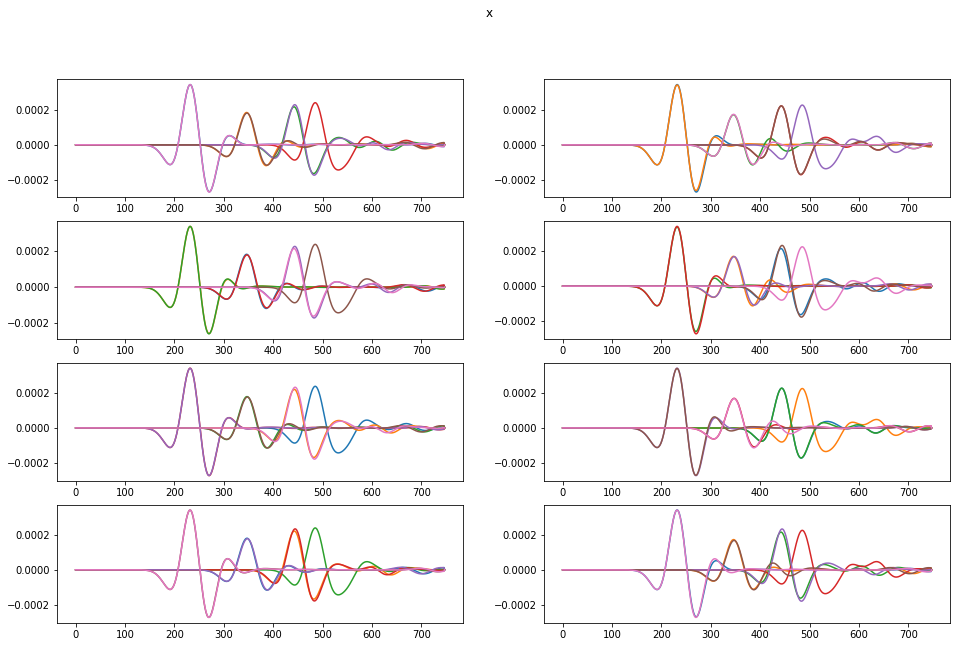

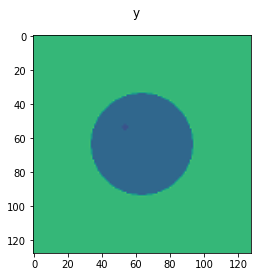

In [ ]:
visualize(x[0],y[0])

In [ ]:
np.unique(x[0].numpy())

array([-0.00027364, -0.00027363, -0.00027334, ...,  0.00034216,
        0.00034273,  0.00034274], dtype=float32)

In [ ]:
x.shape

torch.Size([4, 56, 748])

# Определяем архитектуры

In [ ]:
EMB_DIM = 256
BASE_CHANNEL_SIZE = 8

RESBLOCK = False

ACTIVATION = nn.ELU

# conv blocks

In [ ]:
class ConvBlock(nn.Module):
    def __init__(
        self, 
        in_ch: int, 
        out_ch: int,
        act_fn : object = ACTIVATION,
    ):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            act_fn(),
        )

    def forward(self, x):
        x = self.conv(x)
        return x
    
class ResBlock(nn.Module):
    def __init__(
        self, 
        ch: int, 
        act_fn : object = ACTIVATION,
    ):
        super(ResBlock, self).__init__()
        self.conv1 = ConvBlock(ch,ch)
        self.conv2 = ConvBlock(ch,ch)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.conv1(x1)
        return x + x1
    
class DownLayer(nn.Module):
    def __init__(
        self, 
        in_ch: int, 
        out_ch: int,
    ):
        super(DownLayer, self).__init__()
        self.down = nn.MaxPool2d(2) 
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x


class UpLayer(nn.Module):
    def __init__(
        self,
        in_ch: int, 
        out_ch: int,
        act_fn : object = ACTIVATION,
    ):
        super(UpLayer, self).__init__()

        self.up = nn.ConvTranspose2d(
            in_ch, out_ch,  kernel_size=3,
            output_padding=1, padding=1, 
            stride=2
        )
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = act_fn()

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.act(x)
        return x
    
class Outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

## Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 seq_len=SIZE_CURVE, 
                 n_curves = N_CURVES, 
                 latent_dim : int=EMB_DIM, 
                 act_fn : object = ACTIVATION,
                ):
        super(Encoder, self).__init__()
        size_hidden = 64
        self.nets = nn.ModuleList()
        self.emb_dim = latent_dim
        self.n_curves = n_curves
        for i in range(n_curves):
            tmp = nn.Sequential(
                
                nn.BatchNorm1d(SIZE_CURVE),
                nn.Linear(SIZE_CURVE,SIZE_CURVE),
                nn.BatchNorm1d(SIZE_CURVE),
                act_fn(),
                
                nn.Linear(SIZE_CURVE,SIZE_CURVE//2),
                nn.BatchNorm1d(SIZE_CURVE//2),
                act_fn(),
                
                nn.Linear(SIZE_CURVE//2,size_hidden),
                nn.BatchNorm1d(size_hidden),
                act_fn(),
            )
            self.nets.append(tmp)
        self.fc = nn.Sequential(
            nn.Linear(size_hidden*n_curves,latent_dim*2),
            nn.BatchNorm1d(latent_dim*2),
            act_fn(),
            nn.Linear(latent_dim*2,latent_dim),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x_new = []
        for i in range(self.n_curves):
            x_new.append(self.nets[i](x[:,i,:]))
            
        s = torch.cat(x_new, dim=1)
        return self.fc(s)

In [ ]:
enc = Encoder()

In [ ]:
x.shape

torch.Size([4, 56, 748])

In [ ]:
with torch.no_grad():
    emb = enc(x)

In [ ]:
emb.shape

torch.Size([4, 256])

In [ ]:
x_np = x.numpy()
np.unique(x_np)

array([-0.00027364, -0.00027363, -0.00027334, ...,  0.00034273,
        0.00034274,  0.001     ], dtype=float32)

In [ ]:
np.isnan(emb.numpy()).sum()

0

# Decoder (load)

In [ ]:
class Decoder(nn.Module):
    
    def __init__(
        self, 
        num_input_channels : int, 
        base_channel_size : int, 
        latent_dim : int, 
        act_fn : object = ACTIVATION
    ):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        
        
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, INNER_SIZE*INNER_SIZE*pow(2,DEGREE)*c_hid),
#             nn.BatchNorm1d(INNER_SIZE*INNER_SIZE*pow(2,DEGREE)*c_hid),
#             ACTIVATION(),
        )
        
        self.net = nn.Sequential()
        for deg in reversed(range(DEGREE)):
            if RESBLOCK:
                self.net.add_module(f'rb_{str(deg+1)}', ResBlock(pow(2,deg+1)*c_hid))
            self.net.add_module(f'ul_{str(deg+1)}', UpLayer(pow(2,deg+1)*c_hid, pow(2,deg)*c_hid),)
            
        if RESBLOCK:
            self.net.add_module(f'rb_0', ResBlock(c_hid))
        self.net.add_module('ul_0', UpLayer(c_hid, c_hid))
        
        if RESBLOCK:
            self.net.add_module(f'rb_out', ResBlock(c_hid))
        
        self.net.add_module('ol', Outconv(c_hid, num_input_channels))
        self.net.add_module('act', nn.Sigmoid())
        
        
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, INNER_SIZE, INNER_SIZE)
        x = self.net(x)
        return x

In [ ]:
PATH_dec = '/content/drive/MyDrive/BMM/models/decoder_256'
dec = torch.load(PATH_dec, map_location=torch.device('cpu')).eval().cpu()
for param in dec.parameters():
    param.requires_grad = False

In [ ]:
y_pred = dec(emb)

In [ ]:
y_pred.shape

torch.Size([4, 1, 128, 128])

In [ ]:
model = nn.Sequential(
    enc,
    dec,
)

In [ ]:
with torch.no_grad():
    y_pred = model(x)

In [ ]:
np.unique(y_pred.numpy())

array([0.26401308, 0.2669689 , 0.26797786, ..., 0.7294415 , 0.7299135 ,
       0.7299535 ], dtype=float32)

In [ ]:
y_pred.shape

torch.Size([4, 1, 128, 128])

# Закидываем модель на видеокарту, если она есть

In [ ]:
ngpu = 1
if torch.cuda.is_available():
    print("Cuda is available")
    device = 'cuda:0'
else:
    print('Cuda is not available')
    device='cpu'
torch.cuda.get_device_name(0)

Cuda is available


'Tesla T4'

In [ ]:
model = model.to(device)

RuntimeError: ignored

# Готовимся к обучению сети
фиксируем критерий, выбираем оптимизатор

In [ ]:
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
criterion = nn.MSELoss()

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.5, verbose=True, patience=5)

In [ ]:
EPOCHS = 200

In [ ]:
PATH = '/content/drive/MyDrive/BMM/models/encoder'

In [ ]:
EP_STEP=5

In [ ]:
train_loss_history = []
val_loss_history = []

model.zero_grad()
for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    running_loss = []
    # Train on training dataset
    for steps, (x_batch, y_batch) in enumerate(dataloader_train):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)# x_batch
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
    
    end = time.time()
    train_loss_history.append(np.mean(running_loss))
    print("###############################################")
    print("Epoch: " + str(epoch) + ", Time: " + str(round(end-start, 2)) + "s")
    print("Train loss: " + str(round(train_loss_history[-1],6)))
    scheduler.step(train_loss_history[epoch])
    # Validate the model on every five steps
    if (epoch % EP_STEP != 0):
        continue
        
    # Compute validation loss and accuracy
    running_loss = []
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader_val:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)# x_batch
            running_loss.append(loss.item())
        val_loss_history.append(np.mean(running_loss))
        print('Valid Loss: {}'.format(round(val_loss_history[-1], 6)))
    torch.save(enc, PATH)
    

In [ ]:
plt.figure()
plt.plot(np.log(train_loss_history),label='trainloss')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(np.log(val_loss_history),label='valloss')
plt.legend()
plt.show()

In [ ]:
torch.save(enc, PATH) # .cpu()

# Проверяем на трейне

In [ ]:
model = model.eval()

In [ ]:
x, y = next(iter(dataloader_train))

In [ ]:
with torch.no_grad():
    y_pred = model(x.to(device)).cpu()

In [ ]:
for i in range(x.shape[0]):
    xx = x[i]; yy = y[i]; y_pr = y_pred[i]
    visualize_y(yy,y_pr)

# Проверяем на валидации

In [ ]:
x, y = next(iter(dataloader_val))

In [ ]:
with torch.no_grad():
    y_pred = model(x.to(device)).cpu()

In [ ]:
for i in range(x.shape[0]):
    xx = x[i]; yy = y[i]; y_pr = y_pred[i]
    visualize_y(yy,y_pr)

# In latent space

In [ ]:
with torch.no_grad():
    emb = enc(x.to(device)).cpu()

In [ ]:
with torch.no_grad():
    y_rec = dec(emb.to(device)).cpu()

In [ ]:
idx1 = 2; idx2 = 3

In [ ]:
emb[0].max()

In [ ]:
t=0.5
mid = emb[idx1]+ t*(emb[idx2]-emb[idx1])

with torch.no_grad():
    y_rec_mid = dec(mid.unsqueeze(dim=0).to(device)).cpu()
    
plt.imshow(y_rec_mid[0][0],vmin=0,vmax=1)

In [ ]:
from torchsummary import summary
(summary(model,input_size=x.shape))

# second dataset

In [ ]:
DATADIR_test = f'data/control_datasets/control_dataset_1'
test_idx_list = list(range(0,24))
dataset_test = MyDataset(test_idx_list, DATADIR_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, 
                              shuffle=False,num_workers=N_WERKERS)

In [ ]:
x, y = next(iter(dataloader_test))
with torch.no_grad():
    y_pred = model(x.to(device)).cpu()

In [ ]:
for i in range(x.shape[0]):
    xx = x[i]; yy = y[i]
    visualize_y(yy,y_pred[i])